<a href="https://colab.research.google.com/github/bvchand/Diabetes-detection-in-ICU-patients/blob/main/diabetes_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import sqlite3
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd '/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021'

/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021


In [7]:
#Load all pickled data
KNN_imputed_trainX = pickle.load(open("KNN_imputed_trainX.pkl", "rb"))
KNN_imputed_testX_df = pickle.load(open("KNN_imputed_testX_df.pkl", "rb"))
train_y = pickle.load(open("diabetes_train_y.pkl", "rb"))
test_y = pickle.load(open("diabetes_test_y.pkl", "rb"))

# Logistic regression

In [ ]:
#standardize data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(KNN_imputed_trainX)
scaled_test_df = scaler.fit_transform(KNN_imputed_testX_df)

In [ ]:
# Apply logistic regression
clf = LogisticRegression(random_state=0, max_iter=200).fit(scaled_df, train_y)
pred = clf.predict(scaled_test_df)
score = clf.score(scaled_test_df,test_y)
score

0.7824216349108789

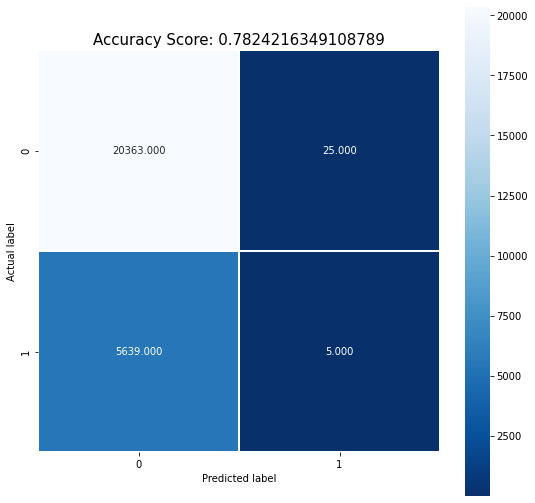

In [ ]:
#show confusion matrix
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Logistic regression has accuracy  score of 78.24 on the dataset.

In [ ]:
# Hyperparameter tuning
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iter = [200,300]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter = max_iter)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
grid_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(scaled_df, train_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.783846 using {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'C': 100}
0.783846 (0.000024) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'C': 100}
0.783846 (0.000024) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 0.1}
0.783846 (0.000024) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'C': 1.0}
0.783846 (0.000024) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'C': 10}
0.783846 (0.000024) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 10}
0.783846 (0.000024) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 1.0}
0.783846 (0.000024) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 300, 'C': 0.01}
0.783846 (0.000024) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 300, 'C': 100}
0.783846 (0.000024) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 0.01}
0.783846 (0.000024) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 20

#SVM

In [8]:
KNN_imputed_trainX = KNN_imputed_trainX[KNN_imputed_testX_df.columns]
KNN_imputed_testX = KNN_imputed_testX_df

In [9]:
#standardize the data for SVM
scaler = StandardScaler()
KNN_imputed_trainX_scaled = scaler.fit_transform(KNN_imputed_trainX)
KNN_imputed_testX_scaled = scaler.transform(KNN_imputed_testX)

KNN_imputed_trainX_scaled_df = pd.DataFrame(KNN_imputed_trainX_scaled, columns=KNN_imputed_trainX.columns, index=KNN_imputed_trainX.index)
print(KNN_imputed_trainX_scaled_df.info)

KNN_imputed_testX_scaled_df = pd.DataFrame(KNN_imputed_testX_scaled, columns=KNN_imputed_testX.columns, index=KNN_imputed_testX.index)
print(KNN_imputed_testX_scaled_df.info)

<bound method DataFrame.info of              age       bmi  ethnicity  ...  d1_sodium_min  d1_wbc_max  d1_wbc_min
115201 -0.119229 -0.042240  -1.884170  ...      -0.078927   -0.392034   -0.300572
5903    0.668470  0.150551   2.787024  ...      -0.150119   -0.420961   -0.262781
68265   0.486693  1.858973  -0.015693  ...      -0.363694   -0.610651   -0.480111
109489  0.365509 -1.298778  -0.015693  ...      -0.150119   -1.021645   -0.950994
14762  -0.664559 -0.812496  -1.884170  ...      -0.150119   -0.015131    0.066886
...          ...       ...        ...  ...            ...         ...         ...
128106 -2.542917 -0.376282  -0.015693  ...      -4.421627   -0.531614   -0.389557
103694  0.001659 -0.887381  -0.015693  ...       1.131334   -0.721303   -0.606887
860     1.516761  0.110271  -0.015693  ...      -0.271145   -0.193070   -0.093746
15795   0.062548  0.267526  -0.015693  ...       1.772060    3.497712    4.226904
121958  0.304917 -0.982155   0.918546  ...       0.277032   -1.132

#### SVM classifier with C=0.1 and a linear kernel



In [ ]:
svm = SVC(C=0.1, kernel='linear', random_state=0)
%time svm.fit(KNN_imputed_trainX_scaled_df, train_y)

In [ ]:
# pickle.dump(svm, open("svm_classifier.pkl", "wb"))
svm = pickle.load(svm, open("svm_classifier.pkl", "rb"))

In [ ]:
diabetes_y_pred = svm.predict(KNN_imputed_testX_scaled_df)

In [ ]:
svm_test_accuracy = accuracy_score(test_y, diabetes_y_pred)

In [ ]:
print("Test accuracy for the SVM classifier with C=0.1 and a linear kernel: ",svm_test_accuracy)

Test accuracy for the SVM classifier with C=0.1 and a linear kernel:  0.7831899200983405


#### SVM classifier with C=1 and a linear kernel



In [ ]:
svm1 = SVC(C=1, kernel='linear', random_state=0)
%time svm1.fit(KNN_imputed_trainX_scaled_df, train_y)

In [ ]:
#pickle.dump(svm1, open("svm_classifier1.pkl", "wb"))
svm1 = pickle.load(open("svm_classifier1.pkl", "rb"))

In [ ]:
diabetes_y_pred_svm1 = svm1.predict(KNN_imputed_testX_scaled_df)

In [ ]:
pickle.dump(diabetes_y_pred_svm1, open("diabetes_y_pred_svm1.pkl", "wb"))
svm_test_accuracy1 = accuracy_score(test_y, diabetes_y_pred_svm1)

In [ ]:
print("Test accuracy for the SVM classifier with C=1 and a linear kernel: ",svm_test_accuracy1)

Test accuracy for the SVM classifier with C=1 and a linear kernel:  0.7831899200983405


# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import accuracy_score
RF_Cl=RandomForestClassifier(n_estimators=200)
start = time.time()
RF_Cl.fit(scaled_df,train_y) #training
end = time.time()
print("Time taken to train data with RFC in seconds :",end-start)

Time taken to train data with RFC in seconds : 193.89659810066223


In [ ]:
RF_Cl.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [ ]:
y_pred = RF_Cl.predict(scaled_test_df) #predicting on the test set

In [ ]:
from sklearn import metrics
print("Accuracy of RFC model:",metrics.accuracy_score(test_y, y_pred))

Accuracy of RFC model: 0.7822295636140135


**Trying randomized SearchCV with RFC**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
random_grid = {#'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 400, 600]}

In [ ]:
rf_random = RandomizedSearchCV(estimator = RF_Cl, param_distributions = random_grid,random_state=42)
# Fit the random search model
rf_random.fit(scaled_df,train_y)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [ ]:
best_random = rf_random.best_estimator_
y_pred = best_random.predict(scaled_test_df) #predicting on the test set
random_accuracy = metrics.accuracy_score(test_y, y_pred)
print("Accuracy for best param model with RFC is :",random_accuracy)

Accuracy for best param model with RFC is : 0.7825752919483713


# XGB

In [ ]:
# data_dmatrix = xgb.DMatrix(data=KNN_imputed_trainX,label=train_y)
# data_test = xgb.DMatrix(data=KNN_imputed_testX_df,label=test_y)

In [ ]:
xg_cl = xgb.XGBClassifier(learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
xg_cl.fit(scaled_df,train_y)
preds = xg_cl.predict(scaled_test_df)

In [ ]:
from sklearn import metrics
print("Accuracy of RFC model:",metrics.accuracy_score(test_y, preds))

Accuracy of RFC model: 0.7831515058389674


# Light GBM

In [58]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(n_estimators=100)
%time clf.fit(KNN_imputed_trainX, train_y)

CPU times: user 9.82 s, sys: 170 ms, total: 9.99 s
Wall time: 5.34 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [59]:
# predict the results
lgb_y_pred=clf.predict(KNN_imputed_testX)

In [60]:
lgb_accuracy=accuracy_score(lgb_y_pred, test_y)
print('LightGBM Model accuracy score: {0:0.4f}'.format(lgb_accuracy))

LightGBM Model accuracy score: 0.7830


# Keras Classifier

In [46]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

# Initialize the constructor
nn_model = Sequential()

# Add an input layer 
nn_model.add(Dense(90, activation='relu', input_dim=90))

# Add two hidden layers 
nn_model.add(Dense(50, activation='relu'))
nn_model.add(Dense(20, activation='relu'))

# Add an output layer 
nn_model.add(Dense(1, activation='sigmoid'))

In [47]:
# Model output shape
nn_model.output_shape

# Model summary
nn_model.summary()

# Model config
nn_model.get_config()

# List all weight tensors 
nn_model.get_weights()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 90)                8190      
_________________________________________________________________
dense_23 (Dense)             (None, 50)                4550      
_________________________________________________________________
dense_24 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 21        
Total params: 13,781
Trainable params: 13,781
Non-trainable params: 0
_________________________________________________________________


[array([[-0.16577545, -0.10326707, -0.12477954, ..., -0.16795342,
          0.07240164,  0.16572744],
        [ 0.13111272, -0.15434593, -0.1049752 , ...,  0.15324742,
         -0.07856772, -0.16017486],
        [-0.07298076,  0.09074247,  0.162575  , ..., -0.02535403,
         -0.1017604 , -0.1290938 ],
        ...,
        [ 0.17068413, -0.00602473,  0.16964892, ..., -0.00466602,
         -0.04568325, -0.13627025],
        [-0.15931968,  0.15522313,  0.01370117, ..., -0.1657841 ,
         -0.13956293,  0.0041209 ],
        [ 0.05842119,  0.14424887,  0.13643235, ...,  0.13434526,
         -0.00870986, -0.14177033]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [48]:
nn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
%time nn_model.fit(KNN_imputed_trainX_scaled, train_y, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
104125/104125 [==============================] - 135s 1ms/step - loss: 0.5280 - accuracy: 0.7835
Epoch 2/20
104125/104125 [==============================] - 136s 1ms/step - loss: 0.5174 - accuracy: 0.7854
Epoch 3/20
104125/104125 [==============================] - 135s 1ms/step - loss: 0.5179 - accuracy: 0.7851
Epoch 4/20
104125/104125 [==============================] - 135s 1ms/step - loss: 0.5192 - accuracy: 0.7832
Epoch 5/20
104125/104125 [==============================] - 135s 1ms/step - loss: 0.5181 - accuracy: 0.7840
Epoch 6/20
104125/104125 [==============================] - 135s 1ms/step - loss: 0.5201 - accuracy: 0.7832
Epoch 7/20
104125/104125 [==============================] - 135s 1ms/step - loss: 0.5148 - accuracy: 0.7868
Epoch 8/20
104125/104125 [==============================] - 135s 1ms/step - loss: 0.5183 - accuracy: 0.7842
Epoch 9/20
104125/104125 [==============================] - 136s 1ms/step - loss: 0.5207 - accuracy: 0.7826
Epoch 10/20
104125/104125 [=

In [57]:
%time nn_y_pred= nn_model.predict(KNN_imputed_testX_scaled_df)
nn_scores = nn_model.evaluate(KNN_imputed_testX_scaled_df, test_y, verbose=0)
print('Accuracy on test data: {}'.format(nn_scores[1]))    

CPU times: user 674 ms, sys: 75.3 ms, total: 749 ms
Wall time: 622 ms
Accuracy on test data: 0.7831898927688599
